In [ ]:
# Import necessary modules
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the path of the Database files
oPath = 'database/tables'
# Read all the sheets from the excel file.
students = pd.read_csv('{}/students.csv'.format(oPath), header = 0)
classes = pd.read_csv('{}/classes.csv'.format(oPath), header = 0)
tests = pd.read_csv('{}/tests.csv'.format(oPath), header = 0)
test_results = pd.read_csv('{}/test_results.csv'.format(oPath), header = 0)
attendance = pd.read_csv('{}/attendance.csv'.format(oPath), header = 0)
hw = pd.read_csv('{}/hw_assignments.csv'.format(oPath), header = 0)
hw_results = pd.read_csv('{}/hw_grades.csv'.format(oPath), header = 0)
participation = pd.read_csv('{}/participation.csv'.format(oPath), header = 0)
# Merge attendance and class ID from students
attendance = pd.merge(attendance, students[['STUDENT_ID', 'CLASS_ID']], how = 'inner', on = 'STUDENT_ID')
# Define a function to show values
def fShowValuesOnBars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.05
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
# Get a list of all class IDs
lClasses = classes['CLASS_ID'].to_list()
# Get a list of student IDs
lStudents = students['STUDENT_ID'].to_list()

In [ ]:
# Set the class ID
tiClassID = 15

# Monthly Report

In [76]:
# Set the month and year
tiYear = 2013
tiMonth = 10
# Get the month name from its number
oMonth = datetime.date(tiYear, tiMonth, 1).strftime('%B')
# Get the number of students in this class
oNumberStudents = students[students['CLASS_ID'] == tiClassID].shape[0]

## For the User-defined Class

### PREPARE DATAFRAMES

In [ ]:
# Students DF
dfStudents = students.where(students['CLASS_ID'] == tiClassID)
dfStudents.dropna(how = 'all', inplace = True)
dfStudents = dfStudents.astype({'STUDENT_ID': 'int32', 'STUDENT_AGE': 'int32', 'CLASS_ID': 'int32'})
dfStudents = dfStudents.reset_index(drop = True)
# Test Scores DF
dfTestScores = test_results.where(test_results['CLASS_ID'] == tiClassID)
dfTestScores.dropna(how = 'all', inplace = True)
dfTestScores = dfTestScores.astype({'STUDENT_ID': 'int32', 'TEST_ID': 'int32', 'TEST_SCORE': 'int32', 'TEST_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})
dfTestScores['TEST_DATE'] = pd.to_datetime(dfTestScores['TEST_DATE'])
dfTestScores = dfTestScores.reset_index(drop = True)
# Get a list of all Test IDs
lTestIDs = dfTestScores['TEST_ID'].unique()
# Attendance DF
dfAttendance = attendance.where(attendance['CLASS_ID'] == tiClassID)
dfAttendance.dropna(how = 'all', inplace = True)
dfAttendance = dfAttendance.astype({'STUDENT_ID': 'int32', 'CLASS_ID': 'int32'})
dfAttendance['CLASS_DATE'] = pd.to_datetime(dfAttendance['CLASS_DATE'])
dfAttendance = dfAttendance.reset_index(drop = True)
# HW Scores DF
dfHWScores = hw_results.where(hw_results['CLASS_ID'] == tiClassID)
dfHWScores.dropna(how = 'all', inplace = True)
dfHWScores = dfHWScores.astype({'STUDENT_ID': 'int32', 'HW_ID': 'int32', 'HW_SCORE': 'int32', 'HW_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})
dfHWScores['HW_ASSIGNED_DATE'] = pd.to_datetime(dfHWScores['HW_ASSIGNED_DATE'])
dfHWScores['HW_TURNED_IN_DATE'] = pd.to_datetime(dfHWScores['HW_TURNED_IN_DATE'])
dfHWScores = dfHWScores.reset_index(drop = True)
# Get a list of all the HW IDs
lHWIDs = dfHWScores['HW_ID'].unique() 
# Participation DF
dfParticipation = participation.where(participation['CLASS_ID'] == tiClassID)
dfParticipation.dropna(how = 'all', inplace = True)
dfParticipation = dfParticipation.astype({'STUDENT_ID': 'int32', 'PARTICIPATION_ATTEMPTS': 'int32', 'PARTICIPATION_HINTS': 'int32', 'CLASS_ID': 'int32'})
dfParticipation['PARTICIPATION_DATETIME'] = pd.to_datetime(dfParticipation['PARTICIPATION_DATETIME'])
dfParticipation = dfParticipation.reset_index(drop = True)
# Tests DF
dfTests = tests[tests['TEST_ID'].isin(lTestIDs)]
dfTests.dropna(how = 'all', inplace = True)
dfTests['TEST_DATE'] = pd.to_datetime(dfTests['TEST_DATE'])
dfTests = dfTests.reset_index(drop = True)
# HW DF
dfHW = hw[hw['HW_ID'].isin(lHWIDs)]
dfHW.dropna(how = 'all', inplace = True)
dfHW['HW_ASSIGNED_DATE'] = pd.to_datetime(dfHW['HW_ASSIGNED_DATE'])
dfHW['HW_DUE_DATE'] = pd.to_datetime(dfHW['HW_DUE_DATE'])
dfHW = dfHW.reset_index(drop = True)

# Filter by Year and Month
dfTestScoresDate = dfTestScores.where((dfTestScores['TEST_DATE'].dt.year == tiYear) & (dfTestScores['TEST_DATE'].dt.month == tiMonth))
dfTestScoresDateMinus1 = dfTestScores.where((dfTestScores['TEST_DATE'].dt.year == tiYear) & (dfTestScores['TEST_DATE'].dt.month == tiMonth - 1))
dfTestScoresDateMinus2 = dfTestScores.where((dfTestScores['TEST_DATE'].dt.year == tiYear) & (dfTestScores['TEST_DATE'].dt.month == tiMonth - 2))
dfAttendanceDate = dfAttendance.where((dfAttendance['CLASS_DATE'].dt.year == tiYear) & (dfAttendance['CLASS_DATE'].dt.month == tiMonth))
dfAttendanceDate.dropna(how = 'all', inplace = True)
dfHWScoresDate = dfHWScores.where((dfHWScores['HW_ASSIGNED_DATE'].dt.year == tiYear) & (dfHWScores['HW_ASSIGNED_DATE'].dt.month == tiMonth))
dfParticipationDate = dfParticipation.where((dfParticipation['PARTICIPATION_DATETIME'].dt.year == tiYear) & (dfParticipation['PARTICIPATION_DATETIME'].dt.month == tiMonth))
dfTestsDate = dfTests.where((dfTests['TEST_DATE'].dt.year == tiYear) & (dfTests['TEST_DATE'].dt.month == tiMonth))
dfHWDate = dfHW.where((dfHW['HW_ASSIGNED_DATE'].dt.year == tiYear) & (dfHW['HW_ASSIGNED_DATE'].dt.month == tiMonth))

# Can use this to loopify the above?
lDFs = [dfStudents, dfTestScores, dfAttendance, dfHWScores, dfParticipation, dfTests, dfHW]

In [ ]:
dfAttendanceAbsent = attendance.where(attendance['ATTENDANCE_STATUS'] == 'absent')
dfAttendanceAbsent.dropna(how = 'all', inplace = True)
dfAttendanceAbsent

### Test Grades

#### *Prepare the DataFrames*

In [ ]:
# Merge the test results DF with students DF for the specified class
dfTestScoresDate = pd.merge(dfTestScoresDate, dfStudents, on = 'STUDENT_ID')
dfTestScoresDateMinus1 = pd.merge(dfTestScoresDateMinus1, dfStudents, on = 'STUDENT_ID')
dfTestScoresDateMinus2 = pd.merge(dfTestScoresDateMinus2, dfStudents, on = 'STUDENT_ID')
# Sort the DF by test score in descending order
dfTestScoresDate = dfTestScoresDate.sort_values(by = 'TEST_SCORE', ascending = False)
dfTestScoresDateMinus1 = dfTestScoresDateMinus1.sort_values(by = 'TEST_SCORE', ascending = False)
dfTestScoresDateMinus2 = dfTestScoresDateMinus2.sort_values(by = 'TEST_SCORE', ascending = False)
# Concat all the Test Score DFs
dfTestScoresTest = pd.concat([dfTestScoresDate, dfTestScoresDateMinus1, dfTestScoresDateMinus2])
# Calculate the average score for each student
dfTestScoresTestAverages = dfTestScoresTest.groupby(['STUDENT_NAME_ENGLISH'])['TEST_SCORE'].mean()
dfTestScoresTestAverages = pd.DataFrame(dfTestScoresTestAverages)
dfTestScoresTestAverages = dfTestScoresTestAverages.append([dfTestScoresTestAverages]*2)
dfTestScoresTestAverages = dfTestScoresTestAverages.sort_values(by = 'STUDENT_NAME_ENGLISH')
dfTestScoresTestAverages['TEST_ID'] = list(range(int(dfTestScoresTest['TEST_ID'].min()), int(dfTestScoresTest['TEST_ID'].max() + 1)))*(int(len(dfTestScoresTestAverages) / 3))

#### *Plots*

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize = (20, 8))
# Plot the data
sns.scatterplot(x='STUDENT_NAME_ENGLISH', y='TEST_SCORE', hue='TEST_ID', data = dfTestScoresTest, ax = ax, s = 150)
# Plot the average test score of all these tests
plt.axhline(y = dfTestScoresTest['TEST_SCORE'].mean(), color = 'lightgrey', linestyle = 'dashed', label = 'All Tests Average')
# Plot the this month's test average score
plt.axhline(y = dfTestScoresTest['TEST_SCORE'].where(dfTestScoresTest['TEST_DATE'].dt.month == tiMonth).mean(), 
            color = 'darkblue', linestyle = 'dashed', label = 'Test {} Average'.format(dfTestScoresTest['TEST_ID'].max()))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Test Scores", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Test Score", size = 18, style="italic")
ax.set(ylim = (-1, 50))
# Add labels
fShowValuesOnBars(ax)

### Homework Grades

#### *Prepare the DataFrames*

In [ ]:
# Merge the HW grades with students DF for the specified class
dfHWScoresDate = pd.merge(dfHWScoresDate, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Calculate the average score for each student
dfHWScoresDateAverages = dfHWScoresDate.groupby(['STUDENT_NAME_ENGLISH'])['HW_SCORE'].mean()
# Turn the above series into a DataFrame
dfHWScoresDateAverages = pd.DataFrame(dfHWScoresDateAverages)

#### *Plots*

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize = (20, 8))
# Plot the data
sns.scatterplot(x='STUDENT_NAME_ENGLISH', y='HW_SCORE', hue='HW_ID', data = dfHWScoresDate, ax = ax, s = 150)
# Plot the this month's HW average score
plt.axhline(y = dfHWScoresDate['HW_SCORE'].where(dfHWScoresDate['HW_ASSIGNED_DATE'].dt.month == tiMonth).mean(), 
            color = 'darkblue', linestyle = 'dashed', label = '{} HW Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("HW Scores", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("HW Score", size = 18, style="italic")
ax.set(ylim = (-1, 10))
# Add labels
fShowValuesOnBars(ax)

### Attendance

#### *Prepare the DataFrames*

In [ ]:
# Merge the attendance DF with the students DF
dfAttendanceDate = pd.merge(dfAttendanceDate, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Group by name and status to get totals for each status by student
dfAttendanceStatus = dfAttendanceDate.groupby(['STUDENT_NAME_ENGLISH', 'ATTENDANCE_STATUS']).count()
# Create new DF of all the instances of an absent status
dfAttendanceDateAbsent = dfAttendanceDate.where(dfAttendanceDate['ATTENDANCE_STATUS'] == 'absent')
# Drop the NANs from this newly created DF
dfAttendanceDateAbsent.dropna(how = 'all', inplace = True)
# Reset the index
dfAttendanceDateAbsent = dfAttendanceDateAbsent.reset_index(drop = True)

#### *Strings/Lists*

In [ ]:
oAbsentCount = dfAttendanceDate['ATTENDANCE_STATUS'].str.contains('absent').sum()
# Print the output
if oAbsentCount > 0:
    # Define a list to store all the instances of absent students
    lAbsences = []
    # Loop through the rows to populate the list
    for index, row in dfAttendanceDateAbsent.iterrows():
        # Pull the name from the current row
        oName = dfAttendanceDateAbsent['STUDENT_NAME_ENGLISH'][index]
        # Pull the date from the current row
        oDate = str(dfAttendanceDateAbsent['CLASS_DATE'][index])[0:10]
        # Define a string to be appended to the list
        sText = '{} was absent on {}'.format(oName, oDate)
        # Append the string to the list
        lAbsences.append(sText)   
else:
    # Define a string to be used in the report
    sMessage = 'No students were absent in {}, {}'.format(oMonth, tiYear)

### Participation

#### *Preparing the DataFrames*

In [113]:
# Merge the student's name with the participation DF
dfParticipationDate = pd.merge(dfParticipationDate, dfStudents[['STUDENT_ID', 'STUDENT_NAME_ENGLISH']], on = 'STUDENT_ID')
# Group by participation type and student ID
dfParticipationDateType = dfParticipationDate.groupby(['STUDENT_ID', 'PARTICIPATION_TYPE'])['PARTICIPATION_TYPE'].count()
dfParticipationDateType = pd.DataFrame(dfParticipationDateType)
dfParticipationDateType = dfParticipationDateType.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'PARTICIPATION_TYPE':'PARTICIPATION_TYPE', 'PARTICIPATION_TYPE':'PART_TYPE_COUNT'})
# Create a pivot table of the same group by
dfParticipationDateTypePivot = dfParticipationDate.pivot_table(index = 'STUDENT_ID', columns = 'PARTICIPATION_TYPE', values = 'STUDENT_ID', aggfunc = 'count')
# Group by student ID and count them to get the total number of participation instances per student
dfParticipationDateCount = dfParticipationDate.groupby(['STUDENT_ID'])['STUDENT_ID'].count()
dfParticipationDateCount = pd.DataFrame(dfParticipationDateCount)

ValueError: Grouper for 'STUDENT_ID' not 1-dimensional

#### *Plots*

##### Participation Instances

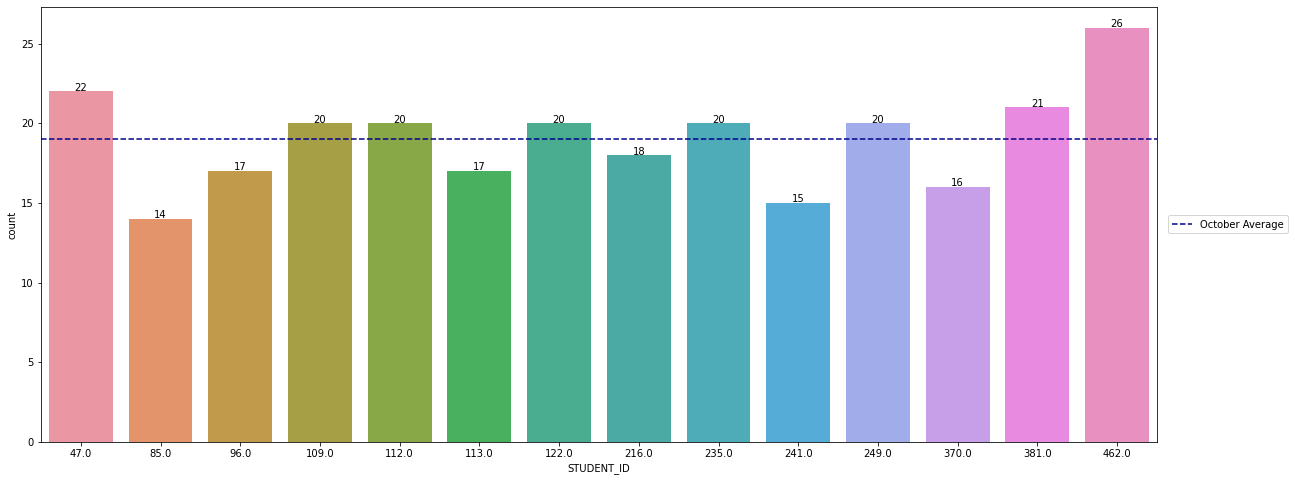

In [111]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize = (20, 8))
# Plot it
sns.countplot(x = 'STUDENT_ID', data = dfParticipationDate)
# Calculate the average
oAverage = dfParticipationDateType['PART_TYPE_COUNT'].sum() / oNumberStudents
# Plot the class average
plt.axhline(y = oAverage, 
            color = 'darkblue', linestyle = 'dashed', label = '{} Average'.format(oMonth))
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Add labels
fShowValuesOnBars(ax)

##### Particpation by Type Distribution

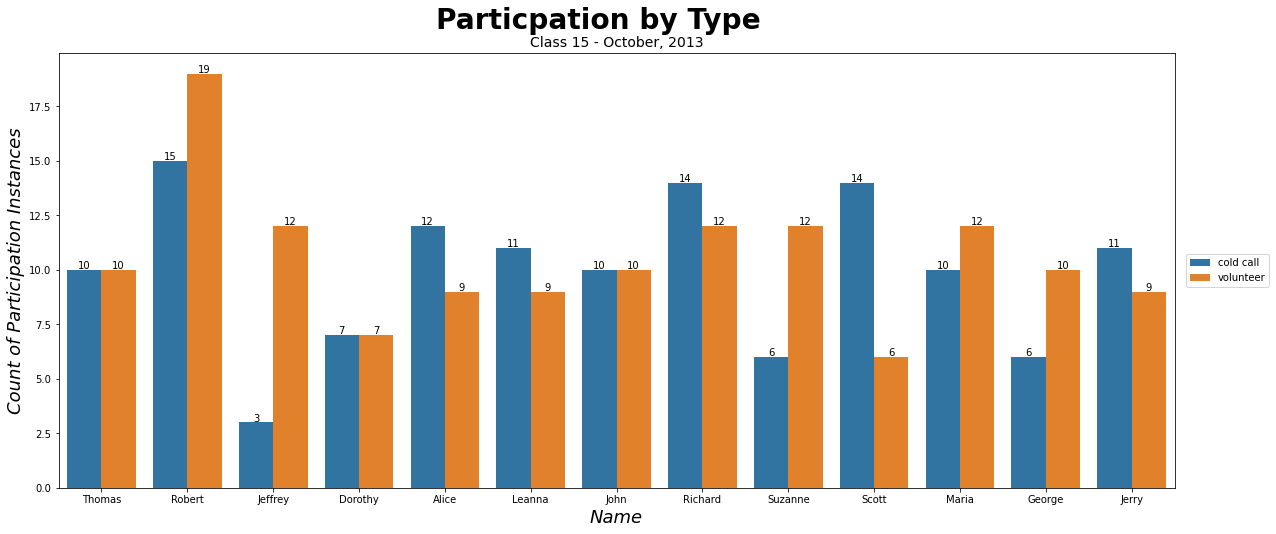

In [57]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize = (20, 8))
# Plot it
sns.countplot(x = 'STUDENT_NAME_ENGLISH', hue = 'PARTICIPATION_TYPE', data = dfParticipationDate)
# Set up the legend
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0)
# Format the graph
tSubtitle = 'Class {} - {}, {}'.format(tiClassID, oMonth, tiYear)
plt.suptitle("Particpation by Type", size = 28, fontweight = "bold", y = 0.96, ha = 'center')
ax.set_title(tSubtitle, size = 14, ha = 'center')
ax.set_xlabel("Name", size = 18, style="italic")
ax.set_ylabel("Count of Participation Instances", size = 18, style="italic")
# Add labels
fShowValuesOnBars(ax)

##### *Strings*

In [ ]:
# List of students who have below average participation instances


In [ ]:
# List of students how have more cold calls than volunteers


#### *Tables*

In [ ]:
# Table of students who have more cold calls than volunteers


In [ ]:
# Table of students who have below average participation instances


## For All Classes

### *Prepare DataFrames*

In [ ]:
 # Define the dictionaries for each DF
dfAllStudents = {}
dfAllTestScores = {}
dfAllAttendance = {}
dfAllHWScores = {}
dfAllParticipation = {}
lAllTestIDs = {}
lAllHWIDs = {}
dfAllTests = {}
dfAllHW = {}
# Loop through all the class IDs to make a DF for each one
for i in lClasses:
    # Students DF
    dfAllStudents[i] = students.where(students['CLASS_ID'] == i)
    dfAllStudents[i].dropna(how = 'all', inplace = True)
    dfAllStudents[i] = dfAllStudents[i].astype({'STUDENT_ID': 'int32', 'STUDENT_AGE': 'int32', 'CLASS_ID': 'int32'})
    dfAllStudents[i] = dfAllStudents[i].reset_index(drop = True)
    # Test Scores DF
    dfAllTestScores[i] = test_results.where(test_results['CLASS_ID'] == i)
    dfAllTestScores[i].dropna(how = 'all', inplace = True)
    dfAllTestScores[i] = dfAllTestScores[i].astype({'STUDENT_ID': 'int32', 'TEST_ID': 'int32', 'TEST_SCORE': 'int32', 'TEST_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})
    dfAllTestScores[i]['TEST_DATE'] = pd.to_datetime(dfAllTestScores[i]['TEST_DATE'])
    dfAllTestScores[i] = dfAllTestScores[i].reset_index(drop = True)
    # Get a list of all Test IDs
    lAllTestIDs[i] = dfTestScores['TEST_ID'].unique()
    # Attendance DF
    dfAllAttendance[i] = attendance.where(attendance['CLASS_ID'] == i)
    dfAllAttendance[i].dropna(how = 'all', inplace = True)
    dfAllAttendance[i] = dfAllAttendance[i].astype({'STUDENT_ID': 'int32', 'CLASS_ID': 'int32'})
    dfAllAttendance[i]['CLASS_DATE'] = pd.to_datetime(dfAllAttendance[i]['CLASS_DATE'])
    dfAllAttendance[i] = dfAllAttendance[i].reset_index(drop = True)
    # HW Scores DF
    dfAllHWScores[i] = hw_results.where(hw_results['CLASS_ID'] == i)
    dfAllHWScores[i].dropna(how = 'all', inplace = True)
    dfAllHWScores[i] = dfAllHWScores[i].astype({'STUDENT_ID': 'int32', 'HW_ID': 'int32', 'HW_SCORE': 'int32', 'HW_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})
    dfAllHWScores[i]['HW_ASSIGNED_DATE'] = pd.to_datetime(dfAllHWScores[i]['HW_ASSIGNED_DATE'])
    dfAllHWScores[i]['HW_TURNED_IN_DATE'] = pd.to_datetime(dfAllHWScores[i]['HW_TURNED_IN_DATE'])
    dfAllHWScores[i] = dfAllHWScores[i].reset_index(drop = True)
    # Get a list of all the HW IDs
    lAllHWIDs[i] = dfHWScores['HW_ID'].unique() 
    # Participation DF
    dfAllParticipation[i] = participation.where(participation['CLASS_ID'] == i)
    dfAllParticipation[i].dropna(how = 'all', inplace = True)
    dfAllParticipation[i] = dfAllParticipation[i].astype({'STUDENT_ID': 'int32', 'PARTICIPATION_ATTEMPTS': 'int32', 'PARTICIPATION_HINTS': 'int32', 'CLASS_ID': 'int32'})
    dfAllParticipation[i]['PARTICIPATION_DATETIME'] = pd.to_datetime(dfAllParticipation[i]['PARTICIPATION_DATETIME'])
    dfAllParticipation[i] = dfAllParticipation[i].reset_index(drop = True)
    # Tests DF
    dfAllTests[i] = tests[tests['TEST_ID'].isin(lTestIDs)]
    dfAllTests[i].dropna(how = 'all', inplace = True)
    dfAllTests[i]['TEST_DATE'] = pd.to_datetime(dfAllTests[i]['TEST_DATE'])
    dfAllTests[i] = dfAllTests[i].reset_index(drop = True)
    # HW DF
    dfAllHW[i] = hw[hw['HW_ID'].isin(lHWIDs)]
    dfAllHW[i].dropna(how = 'all', inplace = True)
    dfAllHW[i]['HW_ASSIGNED_DATE'] = pd.to_datetime(dfAllHW[i]['HW_ASSIGNED_DATE'])
    dfAllHW[i]['HW_DUE_DATE'] = pd.to_datetime(dfAllHW[i]['HW_DUE_DATE'])
    dfAllHW[i] = dfAllHW[i].reset_index(drop = True)

# Define the Dictionaries necessary for the date filter
dfAllTestScoresDate = {}
dfAllAttendanceDate = {}
dfAllHWScoresDate = {}
dfAllParticipationDate = {}
dfAllTestsDate = {}
dfAllHWDate = {}
# Filter by Year and Month
for i in lClasses:
    dfAllTestScoresDate[i] = dfAllTestScores[i].where((dfAllTestScores[i]['TEST_DATE'].dt.year == tiYear) & (dfAllTestScores[i]['TEST_DATE'].dt.month == tiMonth))
    dfAllAttendanceDate[i] = dfAllAttendance[i].where((dfAllAttendance[i]['CLASS_DATE'].dt.year == tiYear) & (dfAllAttendance[i]['CLASS_DATE'].dt.month == tiMonth))
    dfAllHWScoresDate[i] = dfAllHWScores[i].where((dfAllHWScores[i]['HW_ASSIGNED_DATE'].dt.year == tiYear) & (dfAllHWScores[i]['HW_ASSIGNED_DATE'].dt.month == tiMonth))
    dfAllParticipationDate[i] = dfAllParticipation[i].where((dfAllParticipation[i]['PARTICIPATION_DATETIME'].dt.year == tiYear) & (dfAllParticipation[i]['PARTICIPATION_DATETIME'].dt.month == tiMonth))
    dfAllTestsDate[i] = dfAllTests[i].where((dfAllTests[i]['TEST_DATE'].dt.year == tiYear) & (dfAllTests[i]['TEST_DATE'].dt.month == tiMonth))
    dfAllHWDate[i] = dfAllHW[i].where((dfAllHW[i]['HW_ASSIGNED_DATE'].dt.year == tiYear) & (dfAllHW[i]['HW_ASSIGNED_DATE'].dt.month == tiMonth))

# Can use this to loopify the above?
lDFsAll = [dfAllStudents, dfAllTestScores, dfAllAttendance, dfAllHWScores, dfAllParticipation, dfAllTests, dfAllHW]

### *Plots*

# OLD SHIT

## Test Scores

### Create DFs for each Class

In [ ]:
# Create a DataFrame of test results for each class
dfTestsResults = {}
# Loop through the class list
for i in lClasses:
    # Define a DF for the class based on its ID
    dfTestsResults[i] = test_results.where(test_results['CLASS_ID'] == i)
    # Drop the rows with all nans
    dfTestsResults[i].dropna(how = 'all', inplace = True)
    # Reset the index
    dfTestsResults[i] = dfTestsResults[i].reset_index(drop = True)
    # Set the types of columns
    dfTestsResults[i] = dfTestsResults[i].astype({'STUDENT_ID': 'int32', 'TEST_ID': 'int32', 'TEST_SCORE': 'int32', 'TEST_SCORE_MAX': 'int32', 'CLASS_ID': 'int32'})

### Filter a Class's DF by Year and Month

In [ ]:
for i in lClasses:
    # Cast the TEST_DATE column to Datetime
    dfTestsResults[i]['TEST_DATE'] = pd.to_datetime(dfTestsResults[i]['TEST_DATE'])
    # Filter the DF based on year and month
    dfTestsResults[i] = dfTestsResults[i].where(    (dfTestsResults[i]['TEST_DATE'].dt.year == vYear) 
                                                    & (dfTestsResults[i]['TEST_DATE'].dt.month == vMonth)
                                                )
    # Drop null rows
    dfTestsResults[i].dropna(how = 'all', inplace = True)
    # Reset the index
    dfTestsResults[i] = dfTestsResults[i].reset_index(drop = True)
    # Cast the specified columns to their respective types
    dfTestsResults[i] = dfTestsResults[i].astype({'TEST_ID':'int32', 'STUDENT_ID':'int32', 'CLASS_ID':'int32'})
    # Merge their name with the DF
    dfTestsResults[i] = pd.merge(dfTestsResults[i], students, on = 'STUDENT_ID')

#### *Something*

In [ ]:
lTests = dfTestsResults[vClassID]['TEST_ID'].unique()
dfGroup = pd.DataFrame(dfTestsResults[vClassID].groupby(['CLASS_ID', 'TEST_ID'])['TEST_SCORE'].mean())
dfGroup.rename(columns = {'TEST_SCORE':'MEAN_SCORE'})
dfGroup

## Participation

### Average Attempts per Instance

#### *Prepare DataFrames*

In [ ]:
# Prepare a Participation DF for each student
dfPartStudent = {}
for i in lStudents:
    dfPartStudent[i] = participation.where(participation['STUDENT_ID'] == i)
    dfPartStudent[i].dropna(how = 'all', inplace = True)
    dfPartStudent[i] = dfPartStudent[i].astype({'STUDENT_ID': 'int32', 'CLASS_ID': 'int32', 'PARTICIPATION_HINTS': 'int32', 'PARTICIPATION_ATTEMPTS': 'int32'})

In [ ]:
# Prepare a Participation DF for each class
dfPartClass = {}
for i in lClasses:
    dfPartClass[i] = participation.where(participation['CLASS_ID'] == i)
    dfPartClass[i].dropna(how = 'all', inplace = True)
    dfPartClass[i] = dfPartClass[i].astype({'STUDENT_ID': 'int32', 'CLASS_ID': 'int32', 'PARTICIPATION_HINTS': 'int32', 'PARTICIPATION_ATTEMPTS': 'int32'})

In [ ]:
blah = dfPartClass[vClassID]['STUDENT_ID'].unique()
blah

### Average Hints per Instance

#### *Prepare DataFrames*

### Participations Count by Class

#### *Prepare DataFrames*

In [ ]:
# Create new DF from students and participation
dfVOL = pd.merge(students, participation, on = 'STUDENT_ID')
value_counts = dfVOL['STUDENT_ID'].value_counts()
# Convert value_counts to a DataFrame
dfPart = pd.DataFrame(value_counts)
# Reset its index
dfPart = dfPart.reset_index()
# Rename the columns to make them more readable
dfPart.columns = ['STUDENT_ID', 'PARTICIPATIONS COUNT']
# Merge the dfPart and students DataFrames
dfPart = pd.merge(dfPart, students, how = 'outer', on = 'STUDENT_ID')

In [ ]:
# Get the mean number of participations for each class
class_mean = dfPart.groupby('CLASS_ID')['PARTICIPATIONS COUNT'].mean()
# Convert class_mean to a DataFrame
class_mean = pd.DataFrame(class_mean)
# Reset its index
class_mean = class_mean.reset_index()
# Rename the columns
class_mean.columns = ['CLASS_ID', 'MEAN # OF PARTICIPATIONS']
# Merge the class_mean and the dfPart DataFrames 
dfNoPall = pd.merge(dfPart, class_mean, how = 'outer', on = 'CLASS_ID')

In [ ]:
# Get a list of all CLASS_IDs in ascending order
dfSorted = dfNoPall.sort_values(by = 'CLASS_ID')
# Loop through all CLASS_IDs to create a DataFrame for each class
dfNoP = {}
for i in lClasses:
    dfNoP[i] = dfNoPall.where(dfNoPall['CLASS_ID'] == i)
    dfNoP[i].drop(columns = ['STUDENT_FIRST_DAY', 'STUDENT_LAST_DAY'], axis = 0, inplace = True)
    dfNoP[i] = dfNoP[i].dropna(how = 'all')
    dfNoP[i].reset_index(inplace = True, drop = True)
    dfNoP[i] = dfNoP[i].sort_values(by = 'PARTICIPATIONS COUNT', ascending = False).reset_index(drop = True)
    dfNoP[i] = dfNoP[i].astype({'STUDENT_ID': 'int32'})

### Graphs

In [ ]:
# Generate a graph of the count of participations for each student within each class
for i in lClasses:
    tTitle = "Particpation Count by Student for Class {}".format(i)
    # Plot participations count
    pBlah = dfNoP[i].plot.bar(x = "STUDENT_NAME_ENGLISH", y = 'PARTICIPATIONS COUNT', color = 'darkgreen', figsize=(20,12), legend = False)
    # Plot the average as a line on the second axis
    dfNoP[i].plot(x = "STUDENT_NAME_ENGLISH", y = 'MEAN # OF PARTICIPATIONS', ax = pBlah, color = 'lightblue', figsize=(20,12), lw = 4, legend = True)
    # Format the graph
    pBlah.set_title(tTitle, size = 30)
    pBlah.set_xlabel("Name", size = 18)
    pBlah.set_ylabel("Participation Count", size = 18)
    pBlah.legend(["Class Mean: " + str(round(dfNoP[i]['MEAN # OF PARTICIPATIONS'][0]))])
    # Label the bars
    fShowValuesOnBars(pBlah)
    # Save the figure
    pBlah.figure.savefig("images\{}.png".format(tTitle))

## Participations Count Average Per Day

### Prepare DataFrames

In [ ]:
dfByDate = dfVOL.groupby(['STUDENT_ID', 'PARTICIPATION_DATETIME'])['PARTICIPATION_DATETIME'].count()
dfByDate = pd.DataFrame(dfByDate)
dfByDate = dfByDate.rename(columns = {'STUDENT_ID': 'STUDENT_ID', 'PARTICIPATION_DATETIME': 'DATETIME', 'PARTICIPATION_DATETIME': 'COUNT'})

In [ ]:
# Define a dictionary to store each student's DF in
dfPC = {}
# Define a list of Means to store in the new dataframe
lMeans = []
# Loop through the STUDENT_IDs and calculate their mean number of participations
for i in lStudents:
    # Copy the DataFrame for safety resons
    dfa = dfByDate
    # Create a new DF just for the one student
    dfPC[i] = dfa.loc[i]
    # Set their ID to their ID from the list
    dfPC[i]['STUDENT_ID'] = i
    # Calculate the mean participations per class
    dfPC[i]['MEAN'] = dfPC[i]['COUNT'].mean()
    # Sort from highest to lowest count
    dfPC[i] = dfPC[i].sort_values(by = 'COUNT', ascending = False)
    # Append the mean to lMeans
    lMeans.append(dfPC[i]['MEAN'][0])

In [ ]:
# Create a new dataframe of the students and their mean participations per class
dfMeanPart = pd.DataFrame(columns = ['STUDENT_ID', 'MEAN_PARTICIPATIONS_PER_CLASS'])
# Set the student IDs to lStudents which is a list of student IDs
dfMeanPart['STUDENT_ID'] = lStudents
# Set the mean for each student to the corresponding value in lMeans
dfMeanPart['MEAN_PARTICIPATIONS_PER_CLASS'] = lMeans
# Merge the new DF with students
dfMeanPart = pd.merge(dfMeanPart, students, how = 'inner', on = 'STUDENT_ID')
# Drop unneeded columns
dfMeanPart.drop(columns = ['STUDENT_ENROLLED', 'STUDENT_FIRST_DAY', 'STUDENT_LAST_DAY'], inplace = True)

### Graphs

In [ ]:
# Plot the students' means by class
for i in lClasses:
    # Set the title
    tTitle = "Mean Particpations for Class {}".format(i)
    # Filter the DF based on the class ID
    df = dfMeanPart.where(dfMeanPart['CLASS_ID'] == i)
    # Drop rows that are entirely nan
    df.dropna(how = 'all', inplace = True)
    # Sort values from highest to lowest mean participation
    df = df.sort_values(by = 'MEAN_PARTICIPATIONS_PER_CLASS', ascending = False)
    # Create class mean column
    df['CLASS_MEAN'] = df['MEAN_PARTICIPATIONS_PER_CLASS'].mean()
    # Plot participations count
    pBlah = df.plot.bar(x = "STUDENT_NAME_ENGLISH", y = 'MEAN_PARTICIPATIONS_PER_CLASS', color = 'darkgreen', figsize=(20,12), legend = False)
    # Plot the average as a line on the second axis
    df.plot(x = "STUDENT_NAME_ENGLISH", y = 'CLASS_MEAN', ax = pBlah, color = 'lightblue', figsize=(20,12), lw = 4, legend = True)
    # Format the graph
    pBlah.set_title(tTitle, size = 30)
    pBlah.set_xlabel("Name", size = 18)
    pBlah.set_ylabel("Mean Participations per Class", size = 18)
    pBlah.legend(["Class Mean: " + str(round(df['MEAN_PARTICIPATIONS_PER_CLASS'].mean(), 2))])
    # Label the bars
    show_values_on_bars(pBlah)
    # Save the figure
    pBlah.figure.savefig("images\{}.png".format(tTitle))